# Flow Matching: From Intuition to Application

This notebook introduces the basic concepts of **Flow Matching** and shows an application to the simulation of detector data from a CMS-like experiment.

Flow Matching is a powerful framework for generative modeling that learns to transform a simple distribution (like Gaussian noise) into a complex target distribution (like real data). The key idea is to learn a **vector field** that describes how to transport samples from the source to the target distribution.

### Structure

**Part 1: Building Intuition**
- Understanding vector fields and probability paths
- Visualizing conditional paths vs. marginal paths
- 2D Gaussian-to-Gaussian transformation example

**Part 2: Application to CMS Data**
- Building affine probability paths
- Training a neural network to learn the vector field
- Simulating detector-level features

### References
- [Flow Matching Blog Post](https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html)
- We use **PyTorch** as the ML framework for this tutorial

**Time:** ~1 hour for students to go through the material

## Part 1: Understanding Flow Matching

### What do we want?

Let’s assume we have data samples from a distribution of interest $p_1$, whose density is unknown. We’re interested in using these samples to learn a probabilistic model approximating $p_1$ In particular, we want efficient generation of new samples (approximately ) distributed from $p_1$. This task is referred to as **generative modelling**.

Thus we'd like to transform one well-known distribution $p_0$ into another, potentially unknown data distribution $p_1$. ideally, there exists a **marginal probability path** $p_t$ which moves point between the two distribution according to some continuous transformation. Problem: this is a messy and difficult task, expensive to evaluate and to train on.


### So what are we trying to learn?

In Flow Matching, our goal is to learn a **time-dependent vector field** $v_t(x)$ that describes how to continuously transform samples from a simple source distribution $p_0$ (e.g., standard Gaussian) to a complex target distribution $p_1$ (e.g., real data).

Think of it like this:
- At time $t=0$: we have noise from $p_0$
- At time $t=1$: we want to have realistic samples from $p_1$
- In between: the vector field $v_t(x)$ tells us which direction to move each point

The key insight of Flow Matching is that we don't directly learn the complex **marginal** vector field. Instead, we learn simpler **conditional** vector fields $v_t(x|x_1)$ that depend on individual data points $x_1$.

So in the end the loss function will be a simple regression between the output of our NN $v_{\theta}(t,x)$ and this vector field $v_t$.

$$\mathcal{L}_{\text{CFM}}(\theta)=\mathbb{E}_{t}\!\Bigl[\,\bigl\|v_{\theta}(t,x)-v_{t}(x\mid x_{1})\bigr\|^{2}\Bigr]$$

Surprisingly, this loss function is equivalent to approximating the full *marginal* path, so that our network in the end will learn the general transformation mapping between the two distributions.

### Setup: Import Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Set random seed for reproducibility
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch devices: {torch.cuda.device_count()}")

PyTorch version: 2.4.1+cu121
PyTorch devices: 0


### Example: 2D Gaussian to Gaussian

Let's start with a simple example: transforming one 2D Gaussian distribution into another. This will help us visualize the concepts.

We'll define:
- **Source distribution** $p_0$: Standard Gaussian $\mathcal{N}(0, I)$
- **Target distribution** $p_1$: Gaussian $\mathcal{N}(\mu_1, \Sigma_1)$ with different mean and covariance

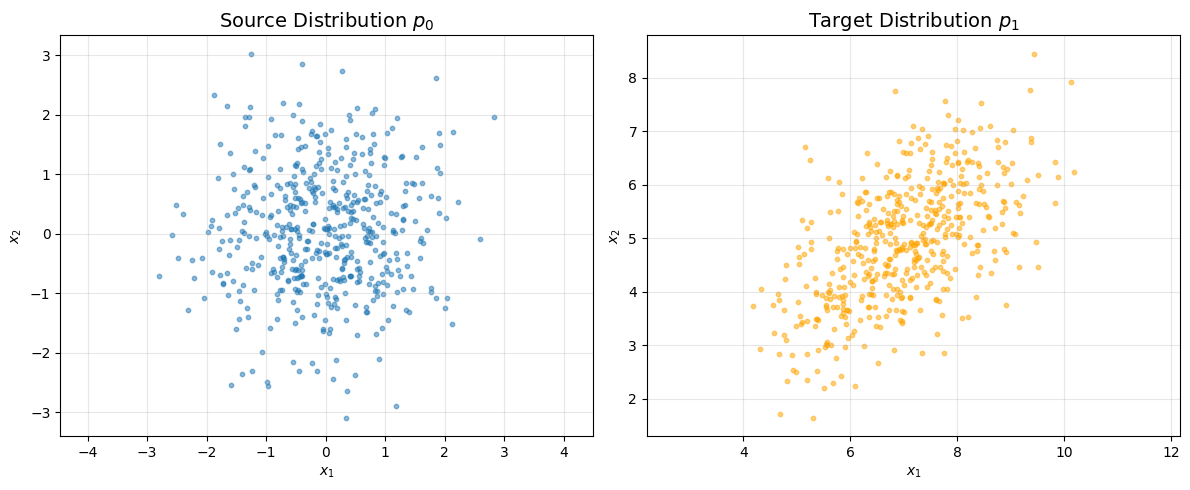

Source mean: tensor([-0.0357,  0.0442])
Target mean: tensor([7.0025, 4.9300])


In [2]:
# Define source and target distributions
def sample_source(n_samples):
    """Sample from source distribution p_0 = N(0, I)"""
    return torch.randn(n_samples, 2)

def sample_target(n_samples):
    """Sample from target distribution p_1 = N(mu_1, Sigma_1)"""
    # Target parameters: shifted and rotated Gaussian
    mu_1 = torch.tensor([7.0, 5.0])
    
    # Create a covariance matrix with correlation
    angle = torch.tensor(torch.pi / 4)  # 45 degree rotation
    rotation = torch.tensor([[torch.cos(angle), -torch.sin(angle)],
                          [torch.sin(angle), torch.cos(angle)]])
    scale = torch.tensor([[2.0, 0.0], [0.0, 0.5]])
    Sigma_1 = rotation @ scale @ rotation.T
    
    # Sample from standard Gaussian and transform
    z = torch.randn(n_samples, 2)
    return z @ torch.linalg.cholesky(Sigma_1).T + mu_1

# Sample from both distributions
n_samples = 500
x_0_samples = sample_source(n_samples)
x_1_samples = sample_target(n_samples)

# Visualize the distributions
# Convert to numpy for plotting
x_0_np = x_0_samples.numpy()
x_1_np = x_1_samples.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x_0_np[:, 0], x_0_np[:, 1], alpha=0.5, s=10)
ax1.set_title('Source Distribution $p_0$', fontsize=14)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

ax2.scatter(x_1_np[:, 0], x_1_np[:, 1], alpha=0.5, s=10, color='orange')
ax2.set_title('Target Distribution $p_1$', fontsize=14)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

plt.tight_layout()
plt.show()

print(f"Source mean: {torch.mean(x_0_samples, dim=0)}")
print(f"Target mean: {torch.mean(x_1_samples, dim=0)}")

### Conditional Probability Paths

The key idea in Flow Matching is to use **conditional probability paths**. Given a target data point $x_1$, we define a path from noise $x_0 \sim p_0$ to $x_1$ at time $t \in [0,1]$, named $p_t (x_t)$ and satisfying the boundary conditions:

$$p_0(\mathbf{x} \mid \mathbf{x}_1) = p_0 \quad\text{and}\quad
p_1(\mathbf{x} \mid \mathbf{x}_1) = \mathcal{N}\!\bigl(\mathbf{x};\,\mathbf{x}_1,\sigma_{\text{min}}^{2}\mathbf{I}\bigr)
\xrightarrow[\sigma_{\text{min}}\to 0]{}\delta_{\mathbf{x}_1}(\mathbf{x})$$

i.e. we shrink from the initial noisy points to our single, conditional data point. If we are transforming from gaussians to gaussians:

![boundary](./figs/heatmap_with_cond_traj-v3.png)

Such a probability path is implemented by a transformation (or *flow*):

$$x_t = \psi_t(x_0, x_1)$$

A simple choice of **affine** path is :
$$x_t = (1 - (1 - \sigma_{\text{min}}) t) x_0 + t x_1$$

This means:
- At $t=0$: $x_t = x_0$ (we start at noise)
- At $t=1$: $x_t = x_1 + \sigma_{\text{min}} x_0 \approx \delta (x_1)$ (we arrive at the data point with an arbitrary small variance from the noise)
- In between: we interpolate according to our transformation (*flow*).

The **conditional vector field** that implements this path can be [shown](https://mlg.eng.cam.ac.uk/2024/01/20/flow-matching.html#gaussian-probability-paths) to be:
$$v_t(x\mid x_1)=\frac{x_1-(1-\sigma_{\text{min}})\,x}{1-(1-\sigma_{\text{min}})\,t}
$$

This above is what we want the NN to learn: given a time $t$ and $x_t$ transformed as above, which is the $v_t(x\mid x_1)$ to move the current $x_t$ closer to the endpoint $x_1$? This is a regression task.

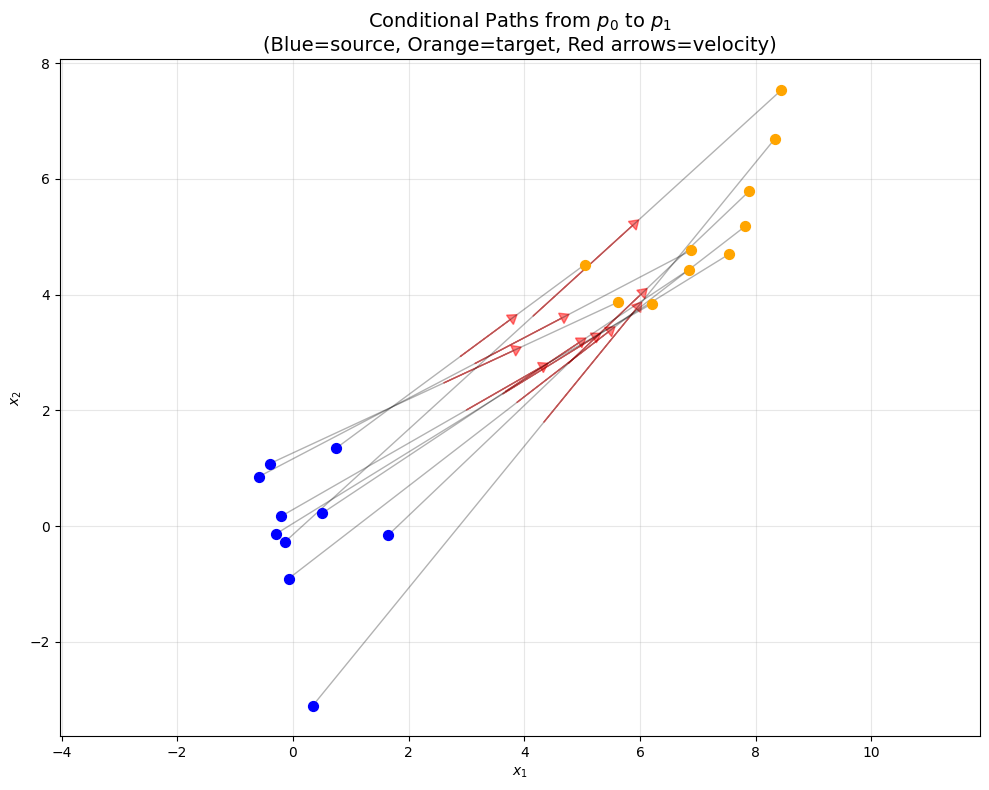

Each black line shows a conditional path from a source point (blue) to a target point (orange)
Red arrows show the velocity vector field at t=0.5
 What if we want to send all the source points to the same target point?


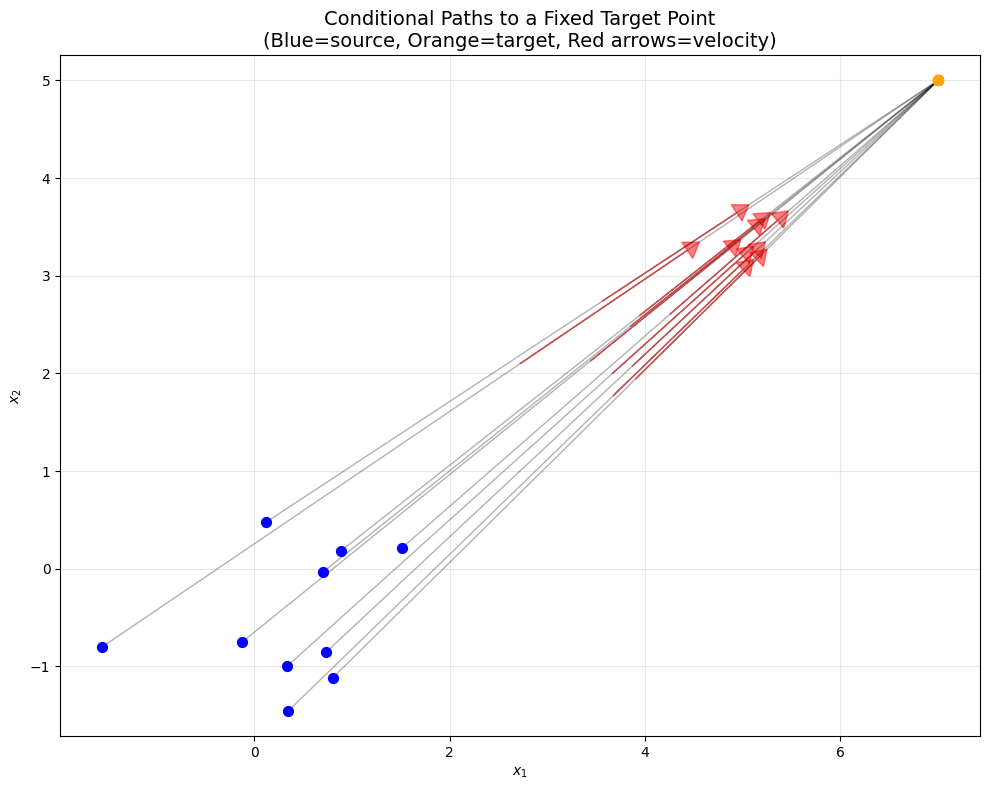

Notice how the path is conditional in the sense that given the target point it attracts or conditions the path of all source points

You can play around with the timestamp parameter in the cell above to see how the magnitude of v_t changes at different times


In [3]:
# Define the affine conditional path
def conditional_path(x_0, x_1, t, sigma_min=0.0001):
    """
    Affine conditional probability path from x_0 to x_1
    
    Args:
        x_0: Source point(s), shape (..., d)
        x_1: Target point(s), shape (..., d)
        t: Time in [0, 1], scalar or shape (...)
        sigma_min: Minimum variance parameter
    
    Returns:
        x_t: Point(s) at time t along the path
    """
    # Ensure t has the right shape for broadcasting
    if isinstance(t, (float, int)):
        t = torch.tensor(t)
    
    t = torch.atleast_1d(t)
    while t.ndim < x_0.ndim:
        t = t.unsqueeze(-1)
    
    return (1 - (1 - sigma_min) * t) * x_0 + t * x_1

def conditional_vector_field(x_0, x_1, t, sigma_min=0.0001):
    """
    Conditional vector field
    
    
    Args:
        x_0: Source point(s)
        x_1: Target point(s)
        t: Time (not used for affine paths, but kept for consistency)
        sigma_min: Minimum variance parameter
    
    Returns:
        Velocity vector
    """
    if isinstance(t, (float, int)):
        t = torch.tensor(t)
        
    t = torch.atleast_1d(t)
    while t.ndim < x_0.ndim:
        t = t.unsqueeze(-1)

    return (x_1 - (1 - sigma_min) * x_0) / (1 - (1 - sigma_min) * t)

# Visualize a few conditional paths
fig, ax = plt.subplots(figsize=(10, 8))

# Take 10 random pairs of (x_0, x_1)
n_paths = 10
timestamp = 0.5
indices = torch.randperm(n_samples)[:n_paths]

# Plot paths
times = torch.linspace(0, 1, 50)
for idx in indices:
    x_0 = x_0_samples[idx]
    x_1 = x_1_samples[idx]
    
    # Compute path
    # Expand x_0, x_1 to (1, 2) and times to (50, 1) for broadcasting
    path = conditional_path(x_0.unsqueeze(0), x_1.unsqueeze(0), times.unsqueeze(1))
    path = path.squeeze(1) # (50, 2)
    
    # Plot path
    path_np = path.numpy()
    ax.plot(path_np[:, 0], path_np[:, 1], 'k-', alpha=0.3, linewidth=1)
    ax.scatter(x_0[0], x_0[1], c='blue', s=50, zorder=5)
    ax.scatter(x_1[0], x_1[1], c='orange', s=50, zorder=5)
    
    # Plot velocity vector at t=0.5
    x_mid = conditional_path(x_0, x_1, timestamp)
    v_mid = conditional_vector_field(x_0, x_1, timestamp)
    ax.arrow(x_mid[0], x_mid[1], v_mid[0]*0.1, v_mid[1]*0.1, 
             head_width=0.2, head_length=0.15, fc='red', ec='red', alpha=0.5)

ax.set_title('Conditional Paths from $p_0$ to $p_1$\n(Blue=source, Orange=target, Red arrows=velocity)', 
             fontsize=14)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

print("Each black line shows a conditional path from a source point (blue) to a target point (orange)")
print("Red arrows show the velocity vector field at t=0.5")
print(" What if we want to send all the source points to the same target point?")

fig, ax = plt.subplots(figsize=(10, 8))
# Take 10 random source points
n_paths = 10
indices = torch.randperm(n_samples)[:n_paths]
fixed_target = torch.tensor([7.0, 5.0])  # Fixed target point

for idx in indices:
    x_0 = x_0_samples[idx]
    x_1 = fixed_target
    
    # Compute path
    path = conditional_path(x_0.unsqueeze(0), x_1.unsqueeze(0), times.unsqueeze(1))
    path = path.squeeze(1)
    
    # Plot path
    path_np = path.numpy()
    ax.plot(path_np[:, 0], path_np[:, 1], 'k-', alpha=0.3, linewidth=1)
    ax.scatter(x_0[0], x_0[1], c='blue', s=50, zorder=5)
    ax.scatter(x_1[0], x_1[1], c='orange', s=50, zorder=5)
    
    # Plot velocity vector at t=0.5
    x_mid = conditional_path(x_0, x_1, timestamp)
    v_mid = conditional_vector_field(x_0, x_1, timestamp)
    ax.arrow(x_mid[0], x_mid[1], v_mid[0]*0.1, v_mid[1]*0.1, 
             head_width=0.2, head_length=0.15, fc='red', ec='red', alpha=0.5)
    
ax.set_title('Conditional Paths to a Fixed Target Point\n(Blue=source, Orange=target, Red arrows=velocity)',
                fontsize=14)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

print("Notice how the path is conditional in the sense that given the target point it attracts or conditions the path of all source points\n")
print("You can play around with the timestamp parameter in the cell above to see how the magnitude of v_t changes at different times")

### Careful! Be mindful of the underlying approximations

Remember we are learning the *conditional* vector field as a proxy for the full *marginal* field implementing the transformation. This works quite well, but it's not perfect. 

One big issue is that due to the fact that during training we sample multiple times from noise, we end up teaching to the network that a nisy sample *x_t* can correspond to multiple endpoints $x_1$, resulting in entangled, non-straight paths.

Compare the marginal paths from gaussian to gaussian below:

![marginal](./figs/g2g-forward_samples.png)

to the conditional paths which we are having the network learning:

![condtional](./figs/g2g-vector-field-samples-cond.png)

You can see quite clearly that it's all tangled up, with points from one end of the starting distribution being connected to point on the other end of the final distribution. This is not always desirable.

### Summary of Part 1

**What we learned:**

1. **Flow Matching learns vector fields** that transport samples from a source distribution (noise) to a target distribution (data)

2. **Conditional paths** $x_t = (1 - (1 - \sigma_{\text{min}}) t) x_0 + t x_1$ provide a simple way to connect noise to each data point

3. **Conditional vector fields** $v_t(x\mid x_1)=\frac{x_1-(1-\sigma_{\text{min}})\,x}{1-(1-\sigma_{\text{min}})\,t}$ are easy to compute and depend on the target point

4. **Different target points** give different conditional fields, each "pulling" toward that specific target

5. **The marginal vector field** $v_t(x) = \mathbb{E}_{x_1}[v_t(x|x_1)]$ is what we actually want ro learn for generation, but it's learned implicitly through the conditional fields

**Key insight:** Flow Matching is clever because we never need to compute the hard marginal field directly. Instead, we:
- Sample pairs $(x_0, x_1)$ from source and target
- Compute simple conditional velocities $v_t(x_t|x_1)$
- Train a neural network to match these velocities
- The network automatically learns to approximate the marginal field!

---

Now let's see how to apply this to real data!

## Introduction: The Compact Muon Solenoid (CMS) experiment

The CMS experiment is a key research project at the Large Hadron Collider (LHC). It's a particle physics detector that observes and measures the byproducts of high-energy particle collisions in the LHC. CMS is designed to investigate a wide range of physics phenomena, and it played a pivotal role in the discovery of the Higgs boson in 2012.

CMS is a general-purpose detector, meaning it's equipped to study various aspects of particle physics. Its main components include a superconducting solenoid magnet, various particle detectors, and systems for tracking, energy measurement, and muon detection. This sophisticated setup allows scientists to explore several key questions in fundamental physics, such as the properties of the Higgs boson, the search for supersymmetry, the nature of dark matter, and potential evidence of extra dimensions.

<!-- insert cms image below -->
![A detailed picture of the CMS detector](./figs/cms_detect.png)


### Measuring jets at CMS

In CMS, particle jets are crucial for understanding high-energy processes. They are sprays of particles formed when quarks and gluons, produced in high-energy collisions like those at the LHC, hadronize or turn into ordinary matter. By analyzing the jets' energy and momentum, physicists can infer properties of the original particles, helping in studies like proton structure, the strong force, and new physics beyond the Standard Model.

![How a jet is generated and reconstructed](./figs/jet_structure.png)


## Hands-on generative models with CMS-like data

In High Energy Physics (HEP), simulations are crucial for understanding the outcomes of particle collisions, like those observed in the CMS experiment.
Each collision can produce a multitude of particles, making the simulation of even a single event a resource-intensive task.

Machine Learning (ML) can significantly speed up this process, particularly the reconstruction phase. By training models to emulate the behavior of particles in the detector and their interaction, we can bypass the need for detailed, step-by-step simulation, reducing computation time and resource usage.

In this second part, we aim to simulate **reconstruction-level** (reco-level) jets from **generator-level** (gen-level) data, i.e. what we reconstructed from the detector readout (reco) given what append at collision point (physics generator). For this purpose, we have prepared a dataset about 2M pairs of gen jets and their associated reco jets as produced by a CMS-like simulation script.


<div class="alert alert-block alert-success" style="background-color:lightgreen; color:green;">

<b>Problem statement:</b> Learn to simulate the features of reco-jets given the values of the associated gen-jet features.
</div>


In [4]:
import numpy as np
import matplotlib.pyplot as plt



In [5]:
# !curl -o data.npy https://zenodo.org/records/11126625/files/gen_ttbar_400k_final.npy

We then extract the data. We are going to use just a subset of the features to reduce the complexity of the problem, and load 1M jets to split into trainig/validation/test. We are going to plot some histograms of the features to better understand what we are talking about.

In [6]:
# a class to load the data taking only some of the features and dividing into reco (target) and gen (input)
class DataExtractor():
    def __init__(self, data_path, n_samples=None):
        self.data = np.load(data_path, allow_pickle=True)
        self.n_samples = n_samples
        self.data = self.data[:n_samples]
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.reco = self.data[:, [5,  6,  7,  8, 10, 19]]
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.gen = self.data[:, [0, 1, 2, 3, 4, 9]]
        # collapse flavour to 3 categories: 0 (light), 1 (charm), 2 (bottom)
        self.gen[:, 4] = np.abs(self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 1, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 2, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 3, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 21, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 5, 2, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 4, 1, self.gen[:, 4])

        
    def get_reco(self):
        return self.reco
    
    def get_gen(self):
        return self.gen

In [7]:
extractor = DataExtractor('data.npy', n_samples=500000)
reco_data = extractor.get_reco()
reco_features = extractor.reco_features
gen_data = extractor.get_gen()
gen_features = extractor.gen_features

#### Plots

We use some utilty functions to plot the target (reco) and input (gen) features to our models. We can use the same functions later on when validating our models!

In [8]:
from utils import plot_1dhistos, plot_corner, make_corner, plot_1d_hist, roc_curve_figure


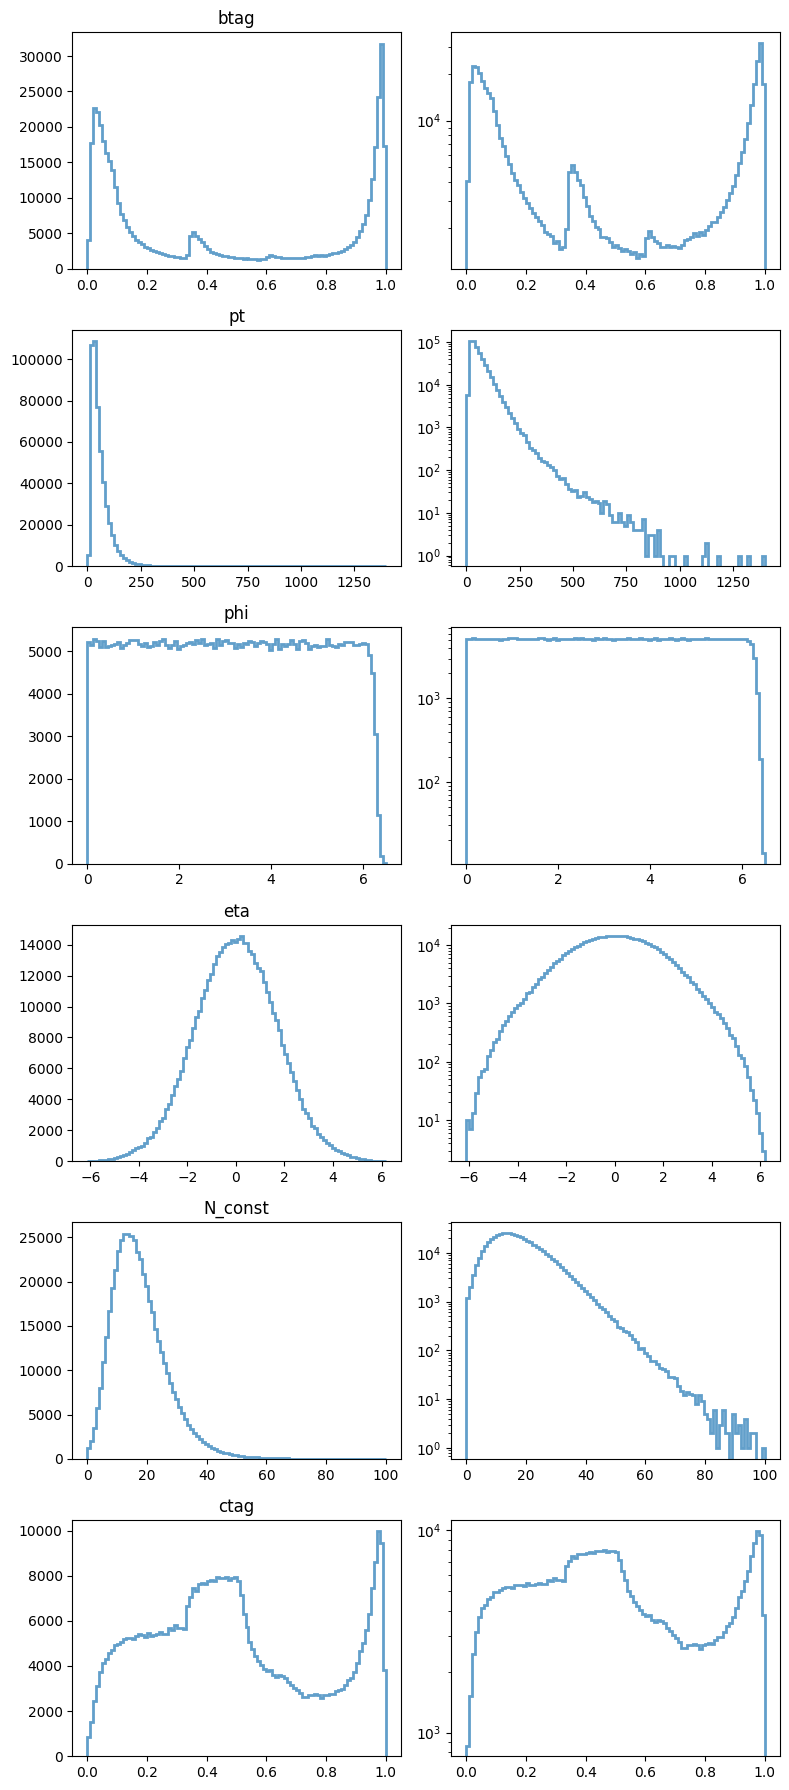

In [9]:
# plot the targets
plot_1dhistos(reco_data, reco_features)

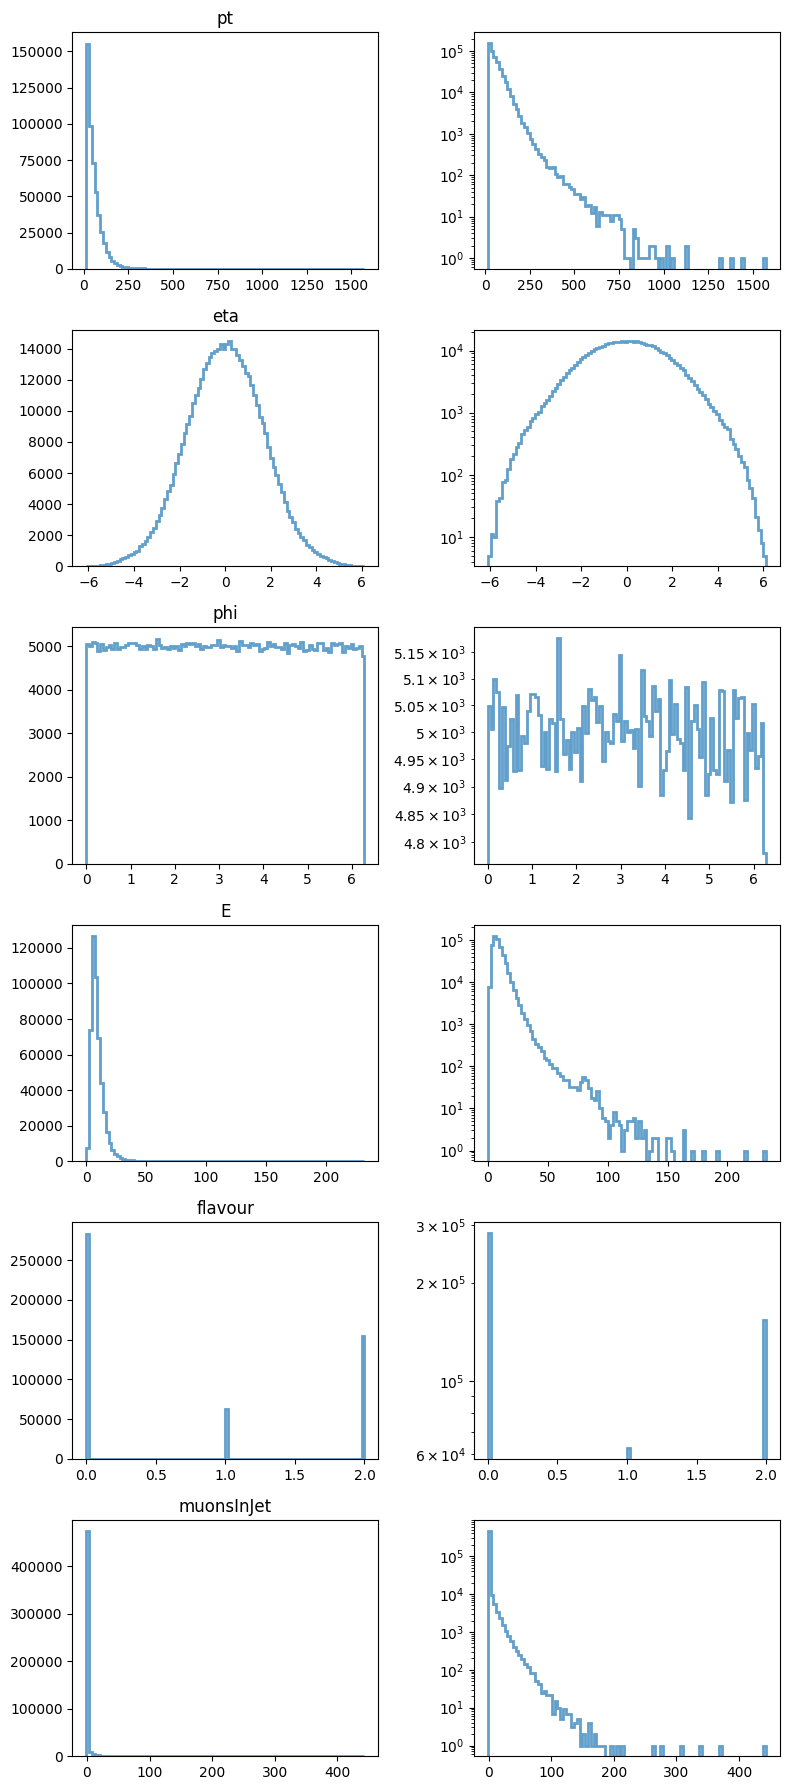

In [10]:
# plot the inputs
plot_1dhistos(gen_data, gen_features)

We can also plot the correlations between the different distributions. We would like our models to capture these as well!

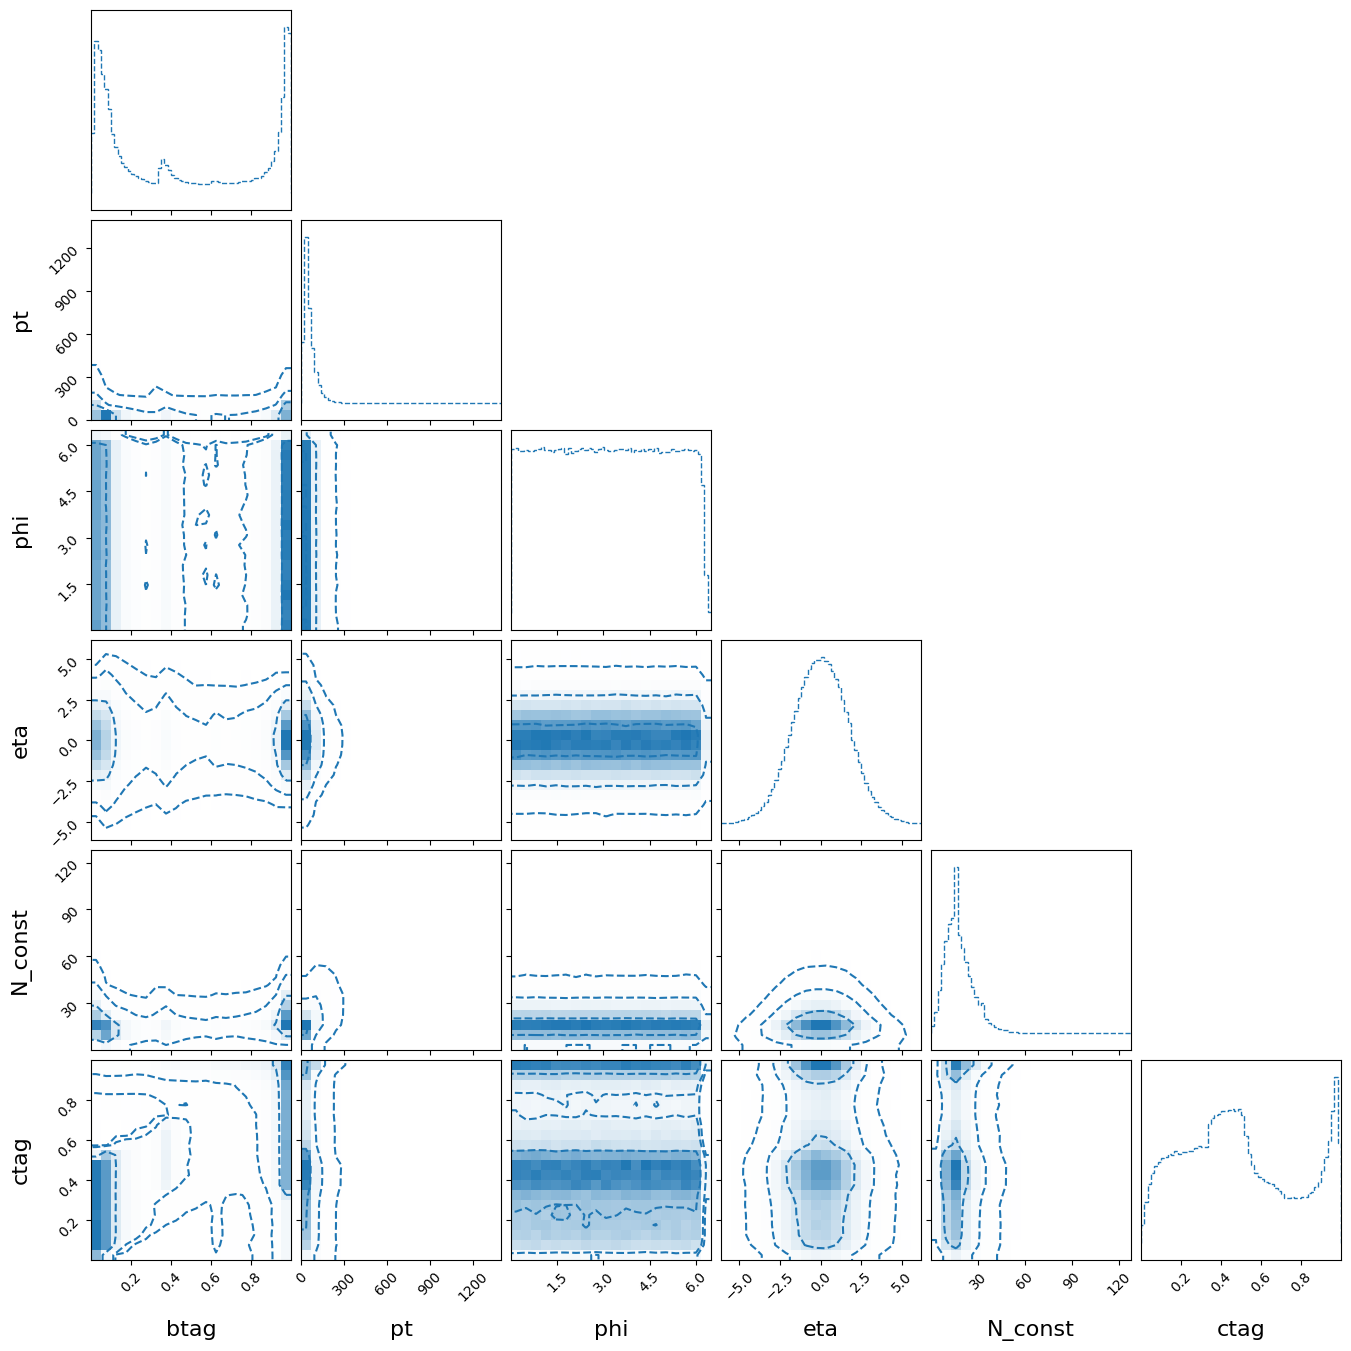

In [11]:
plot_corner(reco_data, reco_features)

#### Preprocessing

We need to preprocess our data. 
The proposed approach is very simple: 
- we standard scale all input features (except for discrete ones);
-  for targets we learn the ratio $p_T^{\text{reco}}/p_T^{\text{gen}}$, the differences $\eta^{\text{reco}} - \eta^{\text{gen}}$ and $\phi^{\text{reco}} - \phi^{\text{gen}}$;
- we standard scale the rest. 
- We also apply some uniform smearning for the number of constituents. 

Feel free to change or add some operations if you think you need them!

In [12]:
### Preprocessor class with transform and invert methods
from sklearn.preprocessing import StandardScaler

class Preprocessor():
    def __init__(self):
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.reco_scaler = StandardScaler()
        self.gen_scaler = StandardScaler()

    def transform(self, reco, gen):
        wreco = np.copy(reco)
        wgen = np.copy(gen)
        # smear N_const
        wreco[:, 4] = wreco[:, 4] + np.random.uniform(-0.5, 0.5, len(wreco))
        # pt ratio
        wreco[:, 1] = wreco[:, 1] / wgen[:, 0]
        # eta difference
        wreco[:, 3] = wreco[:, 3] - wgen[:, 1]
        # phi difference
        wreco[:, 2] = wreco[:, 2] - wgen[:, 2]

        # standard scale the rest
        wreco[:, [0, 4, 5]] = self.reco_scaler.fit_transform(wreco[:, [0, 4, 5]])
        wgen[:, [0, 1, 2, 3]] = self.gen_scaler.fit_transform(wgen[:, [0, 1, 2, 3]])



        return wreco, wgen
    
    def invert(self, reco, gen):

        wreco = np.copy(reco)
        wgen = np.copy(gen)
        
        # invert standard scaling
        wreco[:, [0, 4, 5]] = self.reco_scaler.inverse_transform(wreco[:, [0, 4, 5]])
        wgen[:, [0, 1, 2, 3]] = self.gen_scaler.inverse_transform(wgen[:, [0, 1, 2, 3]])

        # invert pt ratio
        wreco[:, 1] = wreco[:, 1] * wgen[:, 0]
        # invert eta difference
        wreco[:, 3] = wreco[:, 3] + wgen[:, 1]
        # invert phi difference
        wreco[:, 2] = wreco[:, 2] + wgen[:, 2]

        # invert N_const smearing
        wreco[:, 4] = np.rint(wreco[:, 4])

        return wreco, wgen


preprocessor = Preprocessor()
reco_data_transf, gen_data_transf = preprocessor.transform(reco_data, gen_data)

# split the data into training and validation
from sklearn.model_selection import train_test_split

reco_train, reco_val, gen_train, gen_val = train_test_split(reco_data_transf, gen_data_transf, test_size=0.2)
print("Ready to train!")
print("Target data shape: ", reco_train.shape)
print("Input data shape: ", gen_train.shape)
print("Validation data shape: ", reco_val.shape)    
print("Validation data shape: ", gen_val.shape)

reco_train_torch = torch.tensor(reco_train, dtype=torch.float32)
gen_train_torch = torch.tensor(gen_train, dtype=torch.float32)
reco_val_torch = torch.tensor(reco_val, dtype=torch.float32)
gen_val_torch = torch.tensor(gen_val, dtype=torch.float32)

Ready to train!
Target data shape:  (400000, 6)
Input data shape:  (400000, 6)
Validation data shape:  (100000, 6)
Validation data shape:  (100000, 6)


Great! So the arrays we just defined are what we are going to use for our trainings and validations (you can still load data by increasing the `n_samples` in the extractor above, but more data will require more time for training!)

Let's see how the pre-processed features look like: this is what we'll be using as the final target to our models!

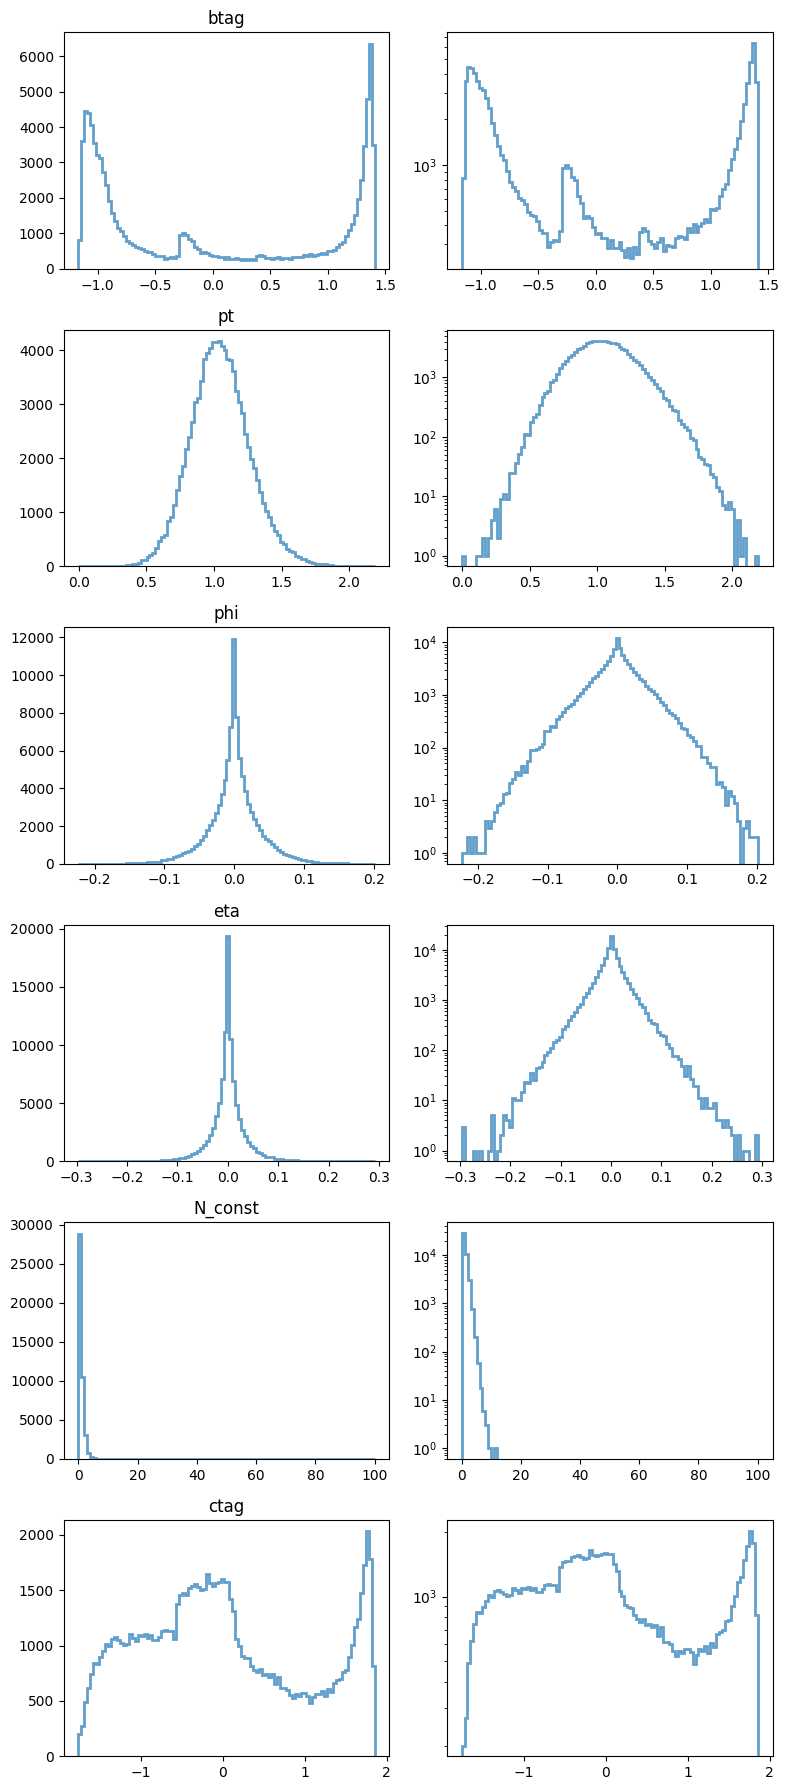

In [13]:
plot_1dhistos(reco_val, reco_features)

In [14]:
# now we implement a simple MLP in JAX to serve as the backbone for learning the vector field
# we should have t+conditioning as input and output the vector field of dimension equal to the reco features




In [15]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class MLP(nn.Module):
    def __init__(self, num_hidden, num_outputs, reco_dim, gen_dim):
        super().__init__()
        # Input dimension: time (1) + reco (reco_dim) + cond (gen_dim)
        input_dim = 1 + reco_dim + gen_dim
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_outputs)
        )

    def forward(self, t, x, cond):
        # Ensure t is correctly shaped for concatenation
        if t.ndim == 0:
            t = t.unsqueeze(0).unsqueeze(0) # (1, 1)
        elif t.ndim == 1:
            t = t.unsqueeze(1) # (Batch, 1)
            
        # If t is scalar but x is batch, expand t
        if t.shape[0] != x.shape[0]:
             t = t.repeat(x.shape[0], 1)

        # Concatenate time embedding, input, and condition
        inputs = torch.cat([t, x, cond], dim=-1)
        return self.net(inputs)

# Instantiate the model
reco_dim = reco_train_torch.shape[1]
gen_dim = gen_train_torch.shape[1]

model = MLP(num_hidden=128, num_outputs=reco_dim, reco_dim=reco_dim, gen_dim=gen_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model and Optimizer created.")

Model and Optimizer created.


In [16]:
# given the training data, compute a batch of vector fields at random times to check their values
batch_size = 256
t_sample = torch.rand(batch_size, 1)
x_0_sample = torch.randn(batch_size, reco_dim)
gen_sample = gen_train_torch[:batch_size]
reco_sample = reco_train_torch[:batch_size]

x_t_sample = conditional_path(x_0_sample, reco_sample, t_sample)
true_v_sample = conditional_vector_field(x_0_sample, reco_sample, t_sample)

# Forward pass
model.eval()
with torch.no_grad():
    pred_v_sample = model(t_sample, x_t_sample, gen_sample)

print("True vector field sample mean:\n", torch.mean(true_v_sample))
print("Predicted vector field sample mean:\n", torch.mean(pred_v_sample))
print("Shape of true vector field sample: ", true_v_sample.shape)
print("Shape of predicted vector field sample: ", pred_v_sample.shape)
print("Code setup complete. You can now proceed with training the model.")
# compute and print MSE
print(f"Loss (MSE) on sample batch: {torch.mean(torch.abs((pred_v_sample - true_v_sample)))}")

True vector field sample mean:
 tensor(3.5501)
Predicted vector field sample mean:
 tensor(-0.0066)
Shape of true vector field sample:  torch.Size([256, 6])
Shape of predicted vector field sample:  torch.Size([256, 6])
Code setup complete. You can now proceed with training the model.
Loss (MSE) on sample batch: 17.883798599243164


In [17]:
# Define the loss function
def compute_loss(model, batch):
    gen_batch, reco_batch = batch
    batch_size = gen_batch.shape[0]
    
    # 1. Sample t and noise
    t = torch.rand(batch_size, 1, device=gen_batch.device)
    x_0 = torch.randn_like(reco_batch) # Source noise
    
    # 2. Compute x_t and the true vector field
    x_t = conditional_path(x_0, reco_batch, t)
    true_v = conditional_vector_field(x_0, reco_batch, t)
    
    # 3. Predict the vector field with the model
    pred_v = model(t, x_t, gen_batch)
    
    # 4. Compute MSE loss (or MAE as in original code)
    return torch.mean(torch.abs(pred_v - true_v))

# The training loop
def train_model(model, optimizer, n_epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for gen_batch, reco_batch in train_loader:
            gen_batch, reco_batch = gen_batch.to(device), reco_batch.to(device)
            
            optimizer.zero_grad()
            loss = compute_loss(model, (gen_batch, reco_batch))
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for gen_batch, reco_batch in val_loader:
                gen_batch, reco_batch = gen_batch.to(device), reco_batch.to(device)
                loss = compute_loss(model, (gen_batch, reco_batch))
                epoch_val_loss += loss.item()
                
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
            
    return train_losses, val_losses

# Create data loaders
from torch.utils.data import TensorDataset, DataLoader

batch_size = 1024
n_epochs = 50

train_dataset = TensorDataset(gen_train_torch, reco_train_torch)
val_dataset = TensorDataset(gen_val_torch, reco_val_torch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Starting training...")
train_losses, val_losses = train_model(model, optimizer, n_epochs, train_loader, val_loader)
print("Training finished.")

Starting training...
Epoch 10/50, Train Loss: 8.1023, Val Loss: 7.8931
Epoch 10/50, Train Loss: 8.1023, Val Loss: 7.8931


KeyboardInterrupt: 

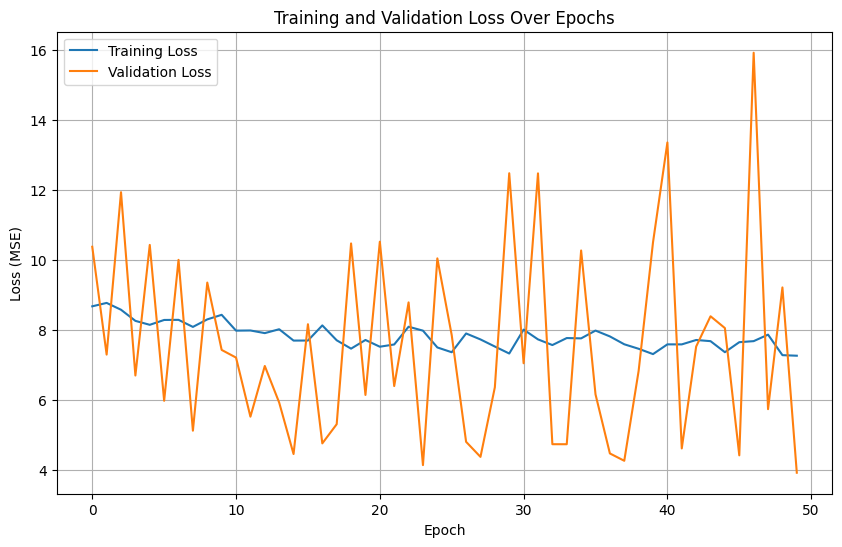

In [ ]:

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


Generating new samples...
Sampling finished.
Sampling finished.


/home/fvaselli/Documents/PHD/ML INFN/flow_matching_introduction/utils.py:342: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(hist_flash) / hist_flash) ** 2 + (np.sqrt(hist_reco) / hist_reco) ** 2
/home/fvaselli/Documents/PHD/ML INFN/flow_matching_introduction/utils.py:344: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/fvaselli/Documents/PHD/ML INFN/flow_matching_introduction/utils.py:345: RuntimeWarning: invalid value encountered in divide
  ratio = hist_flash / hist_reco
/home/fvaselli/Documents/PHD/ML INFN/flow_matching_introduction/utils.py:344: RuntimeWarning: divide by zero encountered in divide
  ratio_err = ratio_err * (hist_flash / hist_reco)
/home/fvaselli/Documents/PHD/ML INFN/flow_matching_introduction/utils.py:345: RuntimeWarning: divide by zero encountered in divide
  ratio = hist_flash / hist_reco
/home/fvaselli/miniconda3/envs/jax/lib/python3.12/site-packages/corner/core.py:928: UserWarning: A

ValueError: It looks like the provided 'range' is not valid or the sample is empty.

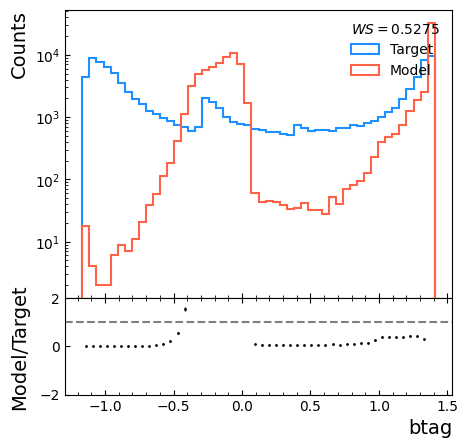

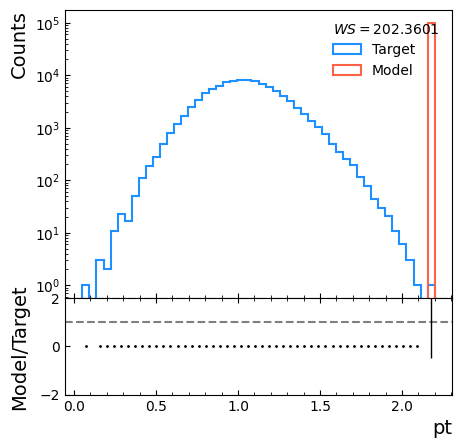

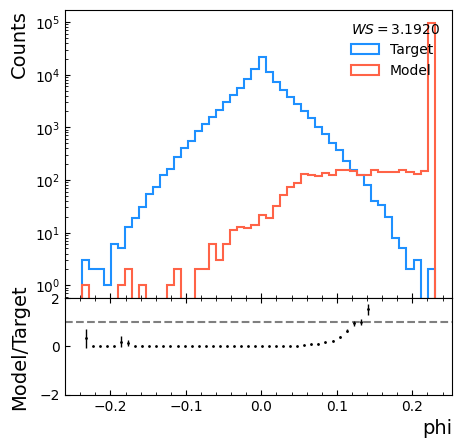

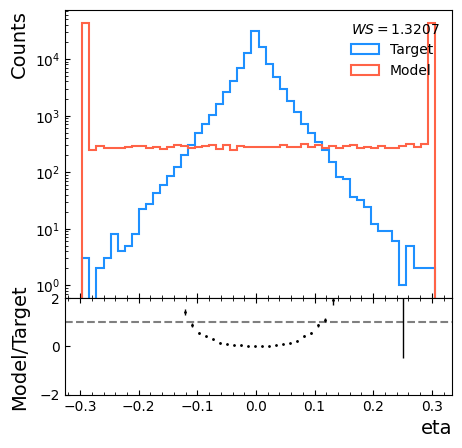

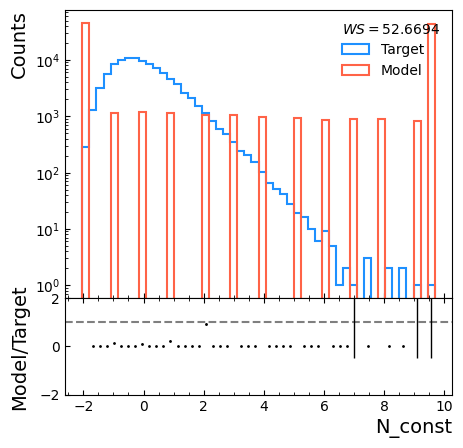

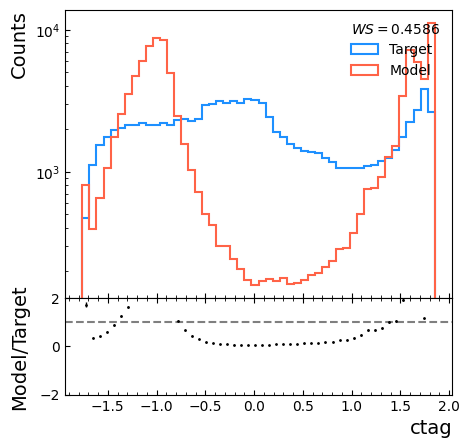

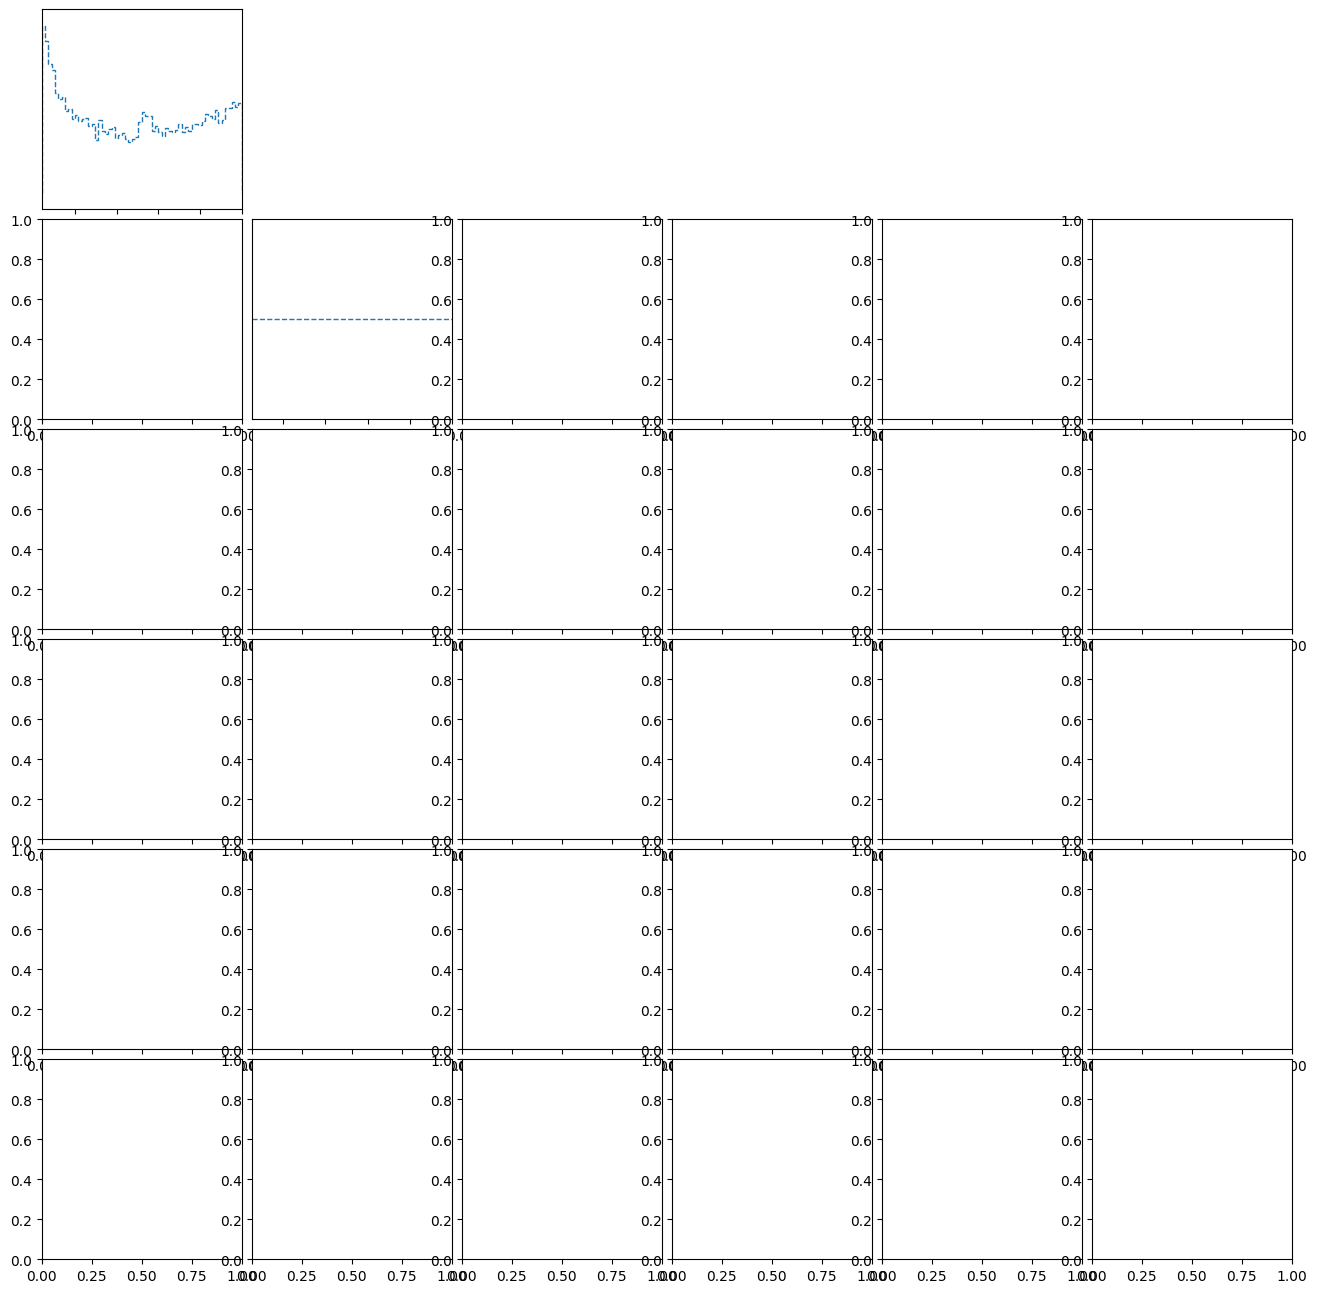

In [ ]:
# A simple Euler ODE solver
def euler_solver(model, y0, cond, n_steps=100):
    """
    A simple Euler ODE solver.
    """
    device = y0.device
    # Time steps from 0 to 1
    ts = torch.linspace(0, 1, n_steps, device=device)
    dt = ts[1] - ts[0]
    y = y0
    
    model.eval()
    with torch.no_grad():
        for t in ts[:-1]: # Don't need to compute v at t=1
            # The model expects inputs with a batch dimension
            t_in = torch.full((y.shape[0], 1), t.item(), device=device)
            
            # Get velocity from the model
            v = model(t_in, y, cond)
            
            # Euler step
            y = y + v * dt
            
    return y

# --- Sampling ---
def sample_from_model(n_samples, gen_conditions, model, n_steps=100):
    """Generate samples from the trained flow matching model."""
    device = next(model.parameters()).device
    gen_conditions = gen_conditions.to(device)
    
    # 1. Sample initial noise from the source distribution p_0
    initial_noise = torch.randn(n_samples, reco_dim, device=device)
    
    # 2. Solve the ODE
    final_samples = euler_solver(model, initial_noise, gen_conditions, n_steps)
    
    return final_samples.cpu().numpy()

# Let's generate some samples using the validation set conditions
n_samples_to_gen = reco_val_torch.shape[0]
gen_conditions_for_sampling = gen_val_torch[:n_samples_to_gen]

print("Generating new samples...")
generated_samples_transf = sample_from_model(n_samples_to_gen, gen_conditions_for_sampling, model)
print("Sampling finished.")

# Invert the preprocessing to get the samples in the original space
generated_samples, _ = preprocessor.invert(generated_samples_transf, gen_val[:n_samples_to_gen])

# Now we can compare the generated samples with the original validation data
# plot
for i in range(6):
    plot_1d_hist(generated_samples[:, i], reco_val[:, i], label=reco_features[i], title=f'Denoised vs Real {reco_features[i]}', bins=50, logScale=True)
make_corner(reco_val, generated_samples, reco_features,"comp")